In [1]:
%%time
import tensorflow as tf
import fastai
from fastai.vision.all import *
from pathlib import Path
from zipfile import ZipFile

CPU times: user 2.74 s, sys: 1.05 s, total: 3.79 s
Wall time: 3.14 s


In [2]:
%%time
#writer = tf.io.TFRecordWriter(FLAGS.output_path)
from tfrecord.tfrecord import *

Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 7.19 ms, sys: 1.1 ms, total: 8.29 ms
Wall time: 6.27 ms


In [3]:
%%time
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 33.9 µs


In [4]:
path = Path.cwd()/"flowers/tfrecords-jpeg-224x224"

In [5]:
%%time
train_fnames = get_files(path/'train', extensions = '.tfrec')
test_fnames = get_files(path/'val', extensions = '.tfrec')

CPU times: user 4.81 ms, sys: 270 µs, total: 5.08 ms
Wall time: 3.07 ms


In [6]:
%%time
data = []
for name in train_fnames + test_fnames :
    r = Reader(str(name), unpack_sample)
    for sample in r :
        data.append([sample['image'][0], sample['class'][0]])
    #break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
CPU times: user 786 ms, sys: 700 ms, total: 1.49 s
Wall time: 2.43 s


In [7]:
%%time

get_x = lambda x: PILImage.create(io.BytesIO(x[0]))

get_y = lambda x: x[1]

def get_items(noop):
    return data

CPU times: user 9 µs, sys: 4 µs, total: 13 µs
Wall time: 19.8 µs


In [8]:
%%time
flowers = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = get_items,
                    get_x = get_x,
                    get_y = get_y,
                    item_tfms = Resize(440),
                    batch_tfms = [*aug_transforms(size = 224, min_scale = 0.75)])

CPU times: user 7.97 ms, sys: 2.26 ms, total: 10.2 ms
Wall time: 9.79 ms


In [9]:
dls = flowers.dataloaders('', bs = 64, device = "cuda")

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


CPU times: user 917 ms, sys: 139 ms, total: 1.06 s
Wall time: 823 ms


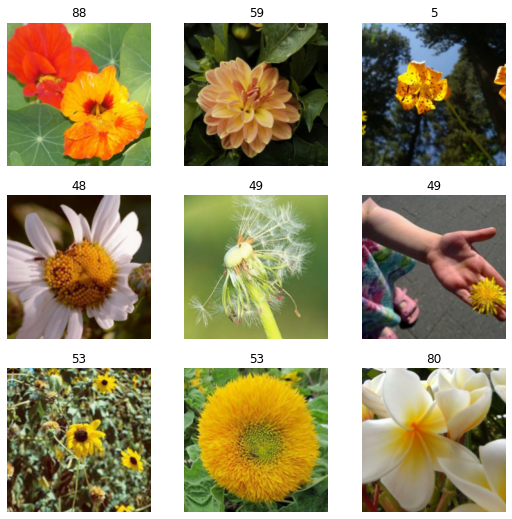

In [10]:
%%time
dls.show_batch()

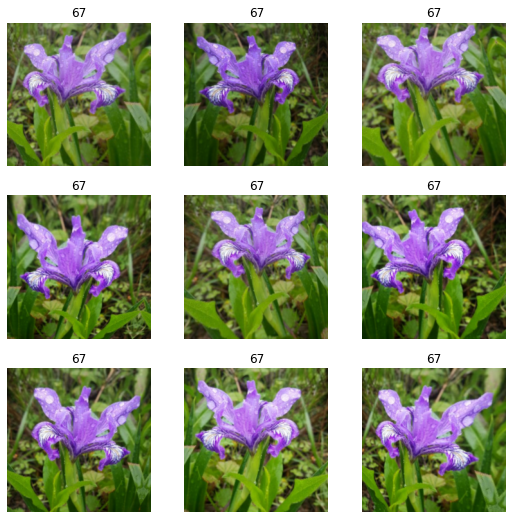

In [11]:
dls.show_batch(unique = True)

In [12]:
%%time

print (len(dls.vocab))

104
CPU times: user 482 µs, sys: 180 µs, total: 662 µs
Wall time: 611 µs


In [14]:
%%time

learn = cnn_learner(dls, resnet34, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

CPU times: user 557 ms, sys: 106 ms, total: 663 ms
Wall time: 448 ms


CPU times: user 15 s, sys: 3 s, total: 18 s
Wall time: 19.9 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.002511886414140463)

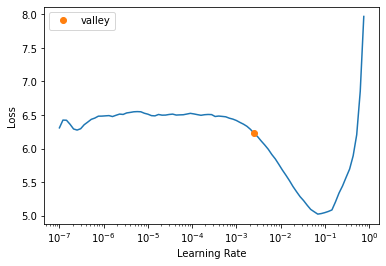

In [15]:
%%time

learn.lr_find()

In [16]:
%%time

learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.756173,1.799242,0.584270,00:45
1,1.334450,1.005934,0.734285,00:45
2,0.927067,0.702045,0.815366,00:45
3,0.633377,0.523633,0.863347,00:45
4,0.446606,0.479109,0.877316,00:45


CPU times: user 3min 3s, sys: 33.8 s, total: 3min 37s
Wall time: 3min 48s


CPU times: user 54.7 ms, sys: 6.16 ms, total: 60.9 ms
Wall time: 55.4 ms


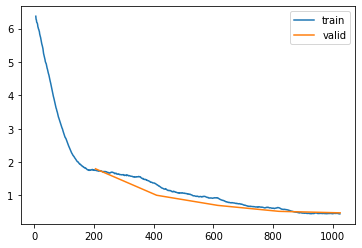

In [17]:
%%time

learn.recorder.plot_loss()

In [19]:
%%time
interp = ClassificationInterpretation.from_learner(learn)


CPU times: user 4.92 s, sys: 4.77 s, total: 9.68 s
Wall time: 8.57 s


CPU times: user 345 ms, sys: 36.1 ms, total: 381 ms
Wall time: 167 ms


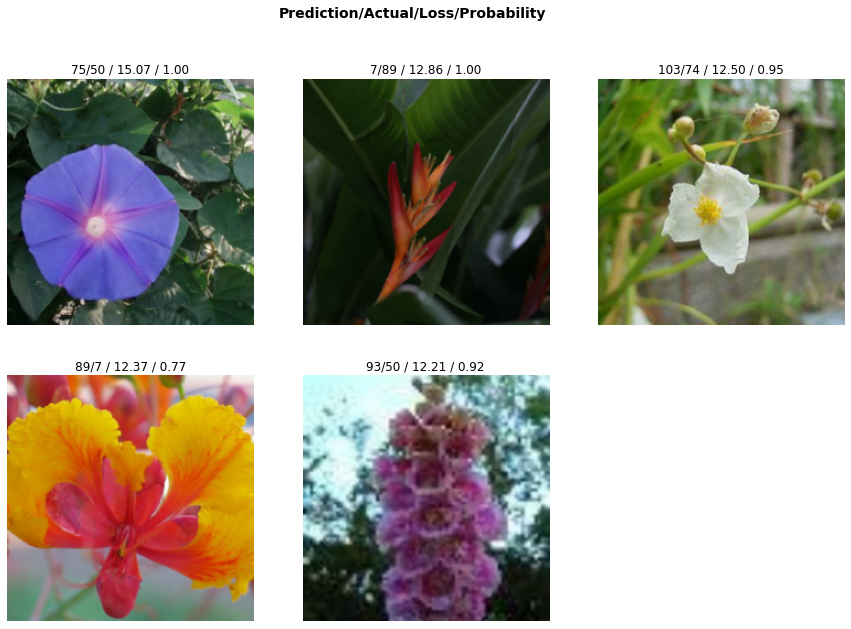

In [20]:
%%time

interp.plot_top_losses(5, nrows = 2, figsize = (15, 10))